In this we build a classfier using deep learning techniques from scratch. In this we have used crossentropy loss to prevent learning slowdown and also used a better weight initialization technique to avoid learning slowdown.

In [1]:
from google.colab import drive
drive.mount('/drive',force_remount=True)

Mounted at /drive


In [2]:
import json
import random
import numpy as np
import sys

In [3]:
def sigmoid(z):
  return 1/(1+np.exp(-z))
def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))
def vectorized_result(j):
  e = np.zeros((10, 1))
  e[j] = 1.0
  return e

In [4]:
class QuadraticCost(object):
  def fn(a,y):
    return (0.5)*(a-y)**(2)
  def delta(z,a,y):
    return (a-y)*sigmoid_prime(z)
class CrossEntropyCost(object):
  def fn(a,y):
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
  def delta(z,a,y):
    return a-y

In [5]:
class Network2(object):
  def __init__(self, sizes,cost=CrossEntropyCost):
    self.num_layers=len(sizes)
    self.sizes=sizes
    self.cost=cost
    self.default_weight_initilizer()

  def default_weight_initilizer(self):
    self.biases=[np.random.randn(y,1) for y in self.sizes[1:]]
    self.weights=[np.random.randn(y,x)/np.sqrt(x) for x,y in zip(self.sizes[:-1], self.sizes[1:])]

  def large_weight_initilizer(self):
    self.biases=[np.random.randn(y,1) for y in self.sizes[1:]]
    self.weights=[np.random.randn(y,x) for x,y in zip(self.sizes[:-1], self.sizes[1:])]
  
  def feedforward(self,a):
    for w,b in zip(self.weights, self.biases):
      a=sigmoid(np.dot(w,a)+b)
    return a
  
  def SGD(self,training_data,n_epoch_strategy,mini_batch_size,eta,lamda=0.0,evaluation_data=None,monitor_evaluation_cost=False,monitor_evaluation_accuracy=False
          ,monitor_training_cost=False,monitor_training_accuracy=False):
    if evaluation_data:
      n_data=len(evaluation_data)
    n=len(training_data)
    evaluation_cost=[]
    training_cost=[]
    evaluation_accuracy=[]
    training_accuracy=[]
    epoch=0
    while epoch < n_epoch_strategy+1 :
      random.shuffle(training_data)
      mini_batches=[training_data[k:k+mini_batch_size] for k in  range(0,n,mini_batch_size)]
      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch,eta,lamda,n)
      print(f"\nEpoch {epoch} training complete.")
      if monitor_training_cost:
        cost=self.total_cost(training_data,lamda)
        training_cost.append(cost)
        print(f"cost on training data: {cost}")

      if monitor_training_accuracy:
        accuracy=self.accuracy(training_data,convert=True)
        training_accuracy.append(accuracy)
        print(f"Accuracy on training data: {accuracy}/{n}")

      if monitor_evaluation_cost:
        cost=self.total_cost(evaluation_data,lamda,convert=True)
        evaluation_cost.append(cost)
        print(f"cost on evaluation data: {cost}")

      if monitor_evaluation_accuracy:
        accuracy=self.accuracy(evaluation_data)
        evaluation_accuracy.append(accuracy)
        print(f"Accuracy on evaluation data: {accuracy}/{n_data}")
      epoch=epoch+1
      print()

    fact=0
    while fact<=7:
      if np.max(evaluation_accuracy[-n_epoch_strategy:])-np.max(evaluation_accuracy[:epoch-n_epoch_strategy]) > 10.0:
          random.shuffle(training_data)
          mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
          for mini_batch in mini_batches:
              self.update_mini_batch(mini_batch, eta, lamda, n)
          print(f"Epoch {epoch} training complete" )
          if monitor_training_cost:
              cost = self.total_cost(training_data, lamda)
              training_cost.append(cost)
              print(f"Cost on training data: {cost}")
          if monitor_training_accuracy:
              accuracy = self.accuracy(training_data, convert=True)
              training_accuracy.append(accuracy)
              print(f"Accuracy on training data: {accuracy} / {n}")
          if monitor_evaluation_cost:
              cost = self.total_cost(evaluation_data, lamda, convert=True)
              evaluation_cost.append(cost)
              print(f"Cost on evaluation data: {cost}")
          if monitor_evaluation_accuracy:
            accuracy = self.accuracy(evaluation_data)
            evaluation_accuracy.append(accuracy)
            print(f"Accuracy on evaluation data: {accuracy} / {n_data}")
          epoch = epoch+1
          print()
          
      else:
          fact = fact+1
          eta = eta/2
            
          random.shuffle(training_data)
          mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
          for mini_batch in mini_batches:
              self.update_mini_batch(mini_batch, eta, lamda, n)
          print("Epoch %s training complete" % epoch)
          if monitor_training_cost:
              cost = self.total_cost(training_data, lamda)
              training_cost.append(cost)
              print(f"Cost on training data: {cost}")
          if monitor_training_accuracy:
              accuracy = self.accuracy(training_data, convert=True)
              training_accuracy.append(accuracy)
              print(f"Accuracy on training data: {accuracy}/{n}")
          if monitor_evaluation_cost:
              cost = self.total_cost(evaluation_data, lamda, convert=True)
              evaluation_cost.append(cost)
              print(f"Cost on evaluation data: {cost}")
          if monitor_evaluation_accuracy:
              accuracy = self.accuracy(evaluation_data)
              evaluation_accuracy.append(accuracy)
              print(f"Accuracy on evaluation data: {accuracy} / {n_data}")
          epoch = epoch+1
          print()
    return evaluation_cost,evaluation_accuracy,training_cost,training_accuracy

  def update_mini_batch(self,mini_batch,eta,lamda,n):
      nabla_b = [np.zeros(b.shape) for b in self.biases]
      nabla_w = [np.zeros(w.shape) for w in self.weights]
      for x, y in mini_batch:
          delta_nabla_b, delta_nabla_w = self.backprop(x, y)
          nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
          nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
      self.weights = [(1-eta*(lamda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
      self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

  def backprop(self,x,y):
    nabla_b=[np.zeros(b.shape) for b in self.biases]
    nabla_w=[np.zeros(w.shape) for w in self.weights]
    activation=x
    activations=[x]
    zs=[]
    for b, w in zip(self.biases, self.weights):
      z=np.dot(w,activation)+b
      zs.append(z)
      activation=sigmoid(z)
      activations.append(activation)
    delta=self.cost.delta(zs[-1],activations[-1],y)
    nabla_b[-1]=delta
    nabla_w[-1]=np.dot(delta,activations[-2].transpose())
    for l in range(2,self.num_layers):
      z=zs[-l]
      sp=sigmoid_prime(z)
      delta=np.dot(self.weights[-l+1].transpose(),delta)*sp
      nabla_b[-l]=delta
      nabla_w[-l]=np.dot(delta,activations[-l-1].transpose())
    return (nabla_b,nabla_w)

  def accuracy(self,data,convert=False):
    if convert:
      results=[(np.argmax(self.feedforward(x)),np.argmax(y)) for x, y in data]
    else:
      results=[(np.argmax(self.feedforward(x)),y) for x,y in data]
    return sum((x==y) for x,y in results)
  
  def total_cost(self, data, lmbda, convert=False):
    cost = 0.0
    for x, y in data:
      a = self.feedforward(x)
      if convert: y = vectorized_result(y)
      cost += self.cost.fn(a, y)/len(data)
    cost += 0.5*(lmbda/len(data))*sum(
    np.linalg.norm(w)**2 for w in self.weights)
    return cost


            
 

In [6]:
import pickle
import gzip
def load_data():
    f = gzip.open(r'/drive/My Drive/MNIST data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    #file_content=f.read()
    #print(file_content)
    f.close()
    return (training_data, validation_data, test_data)

In [7]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

In [8]:
training_data,validation_data,test_data=load_data_wrapper()

In [9]:
training_data,validation_data,test_data=list(training_data),list(validation_data),list(test_data)

#**With Sigmoid+Cross Entropy loss**

# For 1 hidden layer with 30 neurons


In [10]:
cost1=CrossEntropyCost

In [11]:
net=Network2([784,30,10],cost=cost1)

In [12]:
evaluation_cost,evaluation_accuracy,training_cost,training_accuracy=net.SGD(training_data,5,10,0.5,lamda=5.0,evaluation_data=validation_data,monitor_training_accuracy=True,monitor_evaluation_accuracy=True,monitor_training_cost=True,monitor_evaluation_cost=True)


Epoch 0 training complete.
cost on training data: 0.5052034263807588
Accuracy on training data: 46758/50000
cost on evaluation data: 0.8117457259977521
Accuracy on evaluation data: 9367/10000


Epoch 1 training complete.
cost on training data: 0.438028235064204
Accuracy on training data: 47611/50000
cost on evaluation data: 0.8482799614857326
Accuracy on evaluation data: 9525/10000


Epoch 2 training complete.
cost on training data: 0.42055953922155037
Accuracy on training data: 47865/50000
cost on evaluation data: 0.8821124411408757
Accuracy on evaluation data: 9561/10000


Epoch 3 training complete.
cost on training data: 0.4013166181956396
Accuracy on training data: 48028/50000
cost on evaluation data: 0.9011425996682809
Accuracy on evaluation data: 9564/10000


Epoch 4 training complete.
cost on training data: 0.4022244250170884
Accuracy on training data: 48059/50000
cost on evaluation data: 0.9233306787729272
Accuracy on evaluation data: 9584/10000


Epoch 5 training complete.
co

In [13]:
import matplotlib.pyplot as plt


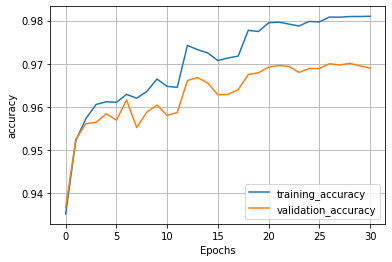

In [14]:
plt.grid()
plt.plot([a/50000 for a in training_accuracy])
plt.plot([e/10000 for e in evaluation_accuracy])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['training_accuracy','validation_accuracy']);

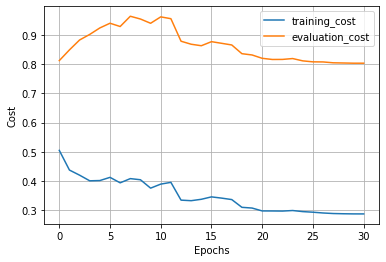

In [15]:
plt.grid()
plt.plot(training_cost)
plt.plot(evaluation_cost)
plt.xlabel("Epochs")
plt.ylabel('Cost')
plt.legend(['training_cost','evaluation_cost'])

In [16]:
print(f"training_accuracy :{(training_accuracy[-1]/50000)*100} %\nvalidation_accuracy: {(evaluation_accuracy[-1]/10000)*100} %\nTest accuracy: {(net.accuracy(test_data)/10000)*100} %")

training_accuracy :98.102 %
validation_accuracy: 96.89999999999999 %
Test accuracy: 96.83 %


#For 2 hidden layers 

In [17]:
net2=Network2([784,100,30,10],cost=cost1)

In [18]:
evaluation_cost,evaluation_accuracy,training_cost,training_accuracy=net2.SGD(training_data,5,10,0.5,lamda=5.0,evaluation_data=validation_data,monitor_training_accuracy=True,monitor_evaluation_accuracy=True,monitor_training_cost=True,monitor_evaluation_cost=True)


Epoch 0 training complete.
cost on training data: 0.3688325321172715
Accuracy on training data: 47939/50000
cost on evaluation data: 0.7884635183642819
Accuracy on evaluation data: 9592/10000


Epoch 1 training complete.
cost on training data: 0.35283556042710684
Accuracy on training data: 48300/50000
cost on evaluation data: 0.9090538562024694
Accuracy on evaluation data: 9617/10000


Epoch 2 training complete.
cost on training data: 0.3018795725151432
Accuracy on training data: 48904/50000
cost on evaluation data: 0.9103370252776936
Accuracy on evaluation data: 9722/10000


Epoch 3 training complete.
cost on training data: 0.2862032194456722
Accuracy on training data: 49042/50000
cost on evaluation data: 0.9381875790055201
Accuracy on evaluation data: 9748/10000


Epoch 4 training complete.
cost on training data: 0.28006151871358764
Accuracy on training data: 49154/50000
cost on evaluation data: 0.9497686364075425
Accuracy on evaluation data: 9745/10000


Epoch 5 training complete.


In [20]:
print(f"training_accuracy :{(training_accuracy[-1]/50000)*100} %\nvalidation_accuracy: {(evaluation_accuracy[-1]/10000)*100} %\n")

training_accuracy :99.842 %
validation_accuracy: 98.22999999999999 %

